# Collision-free Trajectory Optimization in Neural Radiance Fields

## Install L4CasADi and *Dependencies*

In [1]:
import sys

In [ ]:
# @title
!pip install torch --index-url https://download.pytorch.org/whl/cpu
!pip install scikit-build cmake ninja
!pip install git+https://github.com/Tim-Salzmann/l4casadi --no-build-isolation

In [3]:
# @title
!git clone https://github.com/Tim-Salzmann/l4casadi /tmp/l4casadi
sys.path.append('/tmp/l4casadi/examples/nerf_trajectory_optimization')

fatal: destination path '/tmp/l4casadi' already exists and is not an empty directory.


In [4]:
# @title
from density_nerf import DensityNeRF
from nerf_trajectory_optimization import trajectory_generator_solver, polynomial

## Import

In [5]:
import os
import matplotlib.pyplot as plt
import casadi as cs
import torch
import numpy as np

In [6]:
import l4casadi as l4c

## Optimization

In [32]:
# @title Select example case (different start- and goal-points) { run: "auto" }
n = 9
n_eval = 150
optimization_threshold = 1.
viz_threshold = 10.

CASE = "1" # @param ["1", "2", "3"]
CASE = int(CASE)

if CASE == 1:  # case 1
    p_start = np.array([0.0, -0.8, -0.2])
    p_goal = np.array([-0.0, 1.2, 0.8])
elif CASE == 2:  # case 2
    p_start = np.array([0.0, -0.8, -0.2])
    p_goal = np.array([-0.0, 1.2, -0.2])
elif CASE == 3:  # case 3
    p_start = np.array([0.0, -1, 1])
    p_goal = np.array([-0.0, 1.2, -0.2])
else:
    raise ValueError("Invalid case.")

if CASE == 1:
    points = np.array(
        [[0, -0.8, -0.2], [0, -0.5, 0.4], [0, 0, 0.8], [0, 0.75, 0.3], [0, 1.2, 0.8]]
    )
elif CASE == 2:
    points = np.array(
        [[0, -0.8, -0.2], [0, -0.5, 0.4], [0, 0, 0.8], [0, 0.75, 0.4], [0, 1.2, -0.2]]
    )
elif CASE == 3:
    points = np.array(
        [[0.0, -1, 1], [0, -0.85, 0.4], [0, 0, 0.7], [0, 0.75, 0.45], [0, 1.2, -0.2]]
    )
else:
    raise ValueError("Invalid case")

dists = np.linalg.norm(np.diff(points, axis=0), axis=1)
n_eval_points = np.squeeze(dists / np.sum(dists) * n_eval).astype(int)
if np.sum(n_eval_points) != n_eval:
    n_eval_points[-1] += n_eval - np.sum(n_eval_points)
piecewise_points = np.zeros((n_eval, 3))
for k in range(len(points) - 1):
    piecewise_points[
        np.sum(n_eval_points[:k]) : np.sum(n_eval_points[: k + 1]), :
    ] = np.linspace(points[k], points[k + 1], n_eval_points[k] + 1)[:-1, :]

### Load PyTorch NeRF Model

In [ ]:
model = DensityNeRF()
model_path = "/tmp/l4casadi/examples/nerf_trajectory_optimization/nerf_model.tar"
model.load_state_dict(
    torch.load(model_path, map_location="cpu")["network_fn_state_dict"],
    strict=False,
)

### Create L4CasADi Model from PyTorch NeRF

In [10]:
l4c_nerf = l4c.L4CasADi(model)

### Solve First Phase

In [ ]:
# Define Phase 1 NLP
nlp_warm = trajectory_generator_solver(
    n, n_eval, l4c_nerf, warmup=True, threshold=optimization_threshold)

# Solve Phase 1 NLP
params_flat = piecewise_points.T.flatten()  # update nlp to take this as input!
sol = nlp_warm["solver"](p=params_flat, lbg=nlp_warm["lbg"], ubg=nlp_warm["ubg"])

# Extract Phase 1 Solution
coeffs_warm = np.squeeze(sol["x"]).reshape(2, n).T
coeffs_warm = np.hstack([np.zeros((n, 1)), coeffs_warm])

### Optimize Minimum Snap Collision-free Trajectory through NeRF

In [ ]:
# Define NLP
nlp = trajectory_generator_solver(
    n, n_eval, l4c_nerf, warmup=False, threshold=optimization_threshold)

# Solve NLP
x_init = coeffs_warm[:, 1:].T.flatten()
sol = nlp["solver"](x0=x_init, p=params_flat, lbg=nlp["lbg"], ubg=nlp["ubg"])

# Extract Solution
coeffs_sol = np.squeeze(sol["x"]).reshape(2, n).T
coeffs_sol = np.hstack([np.zeros((n, 1)), coeffs_sol])

_, f_eval = polynomial(n, n_eval)
p_sol = np.squeeze(f_eval(coeffs=coeffs_sol)["p"])

### Verify that Trajectory is Collision-free

In [23]:
with torch.no_grad():
    density_sol = model(torch.tensor(p_sol, dtype=torch.float32)).detach()[..., 0]

print(f"Maximum Density in Solution: {density_sol.max()} < Threshold {optimization_threshold:.2f}")

Maximum Density in Solution: 0.3710833191871643 < Threshold 1.00


## Visualize Result

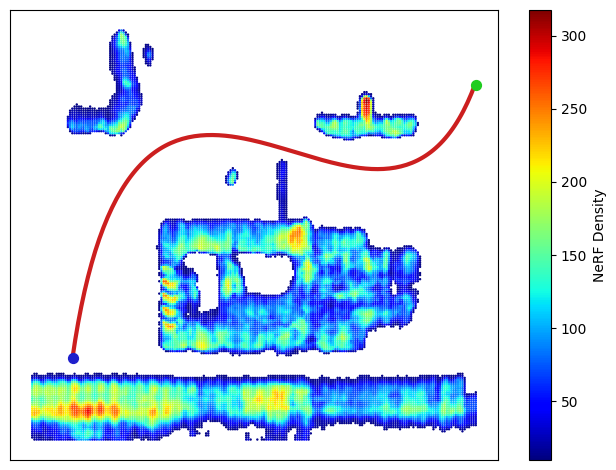

In [24]:
meshgrid = torch.meshgrid(
    torch.linspace(0, 0, 1),
    torch.linspace(-1.0, 1.2, 200),
    torch.linspace(-0.5, 1, 200),
    indexing='ij'
)

points = torch.stack(meshgrid, dim=-1).reshape(-1, 3)
with torch.no_grad():
    density = model(points).detach()[..., 0]
points = points.numpy()

ax = plt.figure().add_subplot(111)
ax.plot(p_sol[:, 1], p_sol[:, 2], "-", color=(0.8, 0.12, 0.12), linewidth=3)
g = ax.scatter(
    points[density > viz_threshold][:, 1],
    points[density > viz_threshold][:, 2],
    cmap="jet",
    c=density[density > viz_threshold],
    s=0.5,
)
cb = plt.colorbar(g, ax=ax)
ax.scatter(p_start[1], p_start[2], color=(0.12, 0.12, 0.8), s=50., zorder=10)
ax.scatter(p_goal[1], p_goal[2], color=(0.12, 0.8, 0.12), s=50., zorder=10)
cb.set_label('NeRF Density')
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout()
plt.show()